In [ ]:
#what improvements can I get over the RF
    #try xgboost and NN
#read the RF in and get performance
#build xgb

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
df=pd.read_csv("/home/cdsw/train_for_mod2_v1.csv")

In [13]:
df_check=df
df_check["AV3Months"]=df.loc[: , "Shop_min3":"Shop_min1"].mean(axis=1)
df_check2=df_check[df_check.AV3Months >1]
df_check2.drop(df_check2.columns.to_series().loc["Unnamed: 0":"shop_id"],axis=1,inplace=True)
#split into train and test set
Y1=df_check2[["Target"]]
X1=df_check2.drop(["Target"],axis=1)

X_train1, X_test1,Y_train1, Y_test1 = train_test_split(X1,Y1,test_size=0.3, 
                                                   random_state=428)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [4]:
with open("/home/cdsw/Models/mod2_rf_1000_min5_v2", 'rb') as file:
    rf2 = pickle.load(file)
compare=Y_test1
compare.reset_index(drop=True,inplace=True)

yhat2=pd.Series(rf2.predict(X_test1))
compare["preds2"]=round(yhat2,0).astype("int64")

#compare2=pd.concat([compare, adds],axis=0)
print("RMSE of RF Model:", mean_squared_error(compare.Target,compare.preds2)**0.5)

RMSE of RF Model: 0.5952289546696087


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [15]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import time
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train1, 
    Y_train1, 
    eval_metric="rmse", 
    eval_set=[(X_train1, Y_train1), (X_test1, Y_test1)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[15:58:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.863143	validation_1-rmse:0.834613
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.834165	validation_1-rmse:0.805369
[2]	validation_0-rmse:0.809685	validation_1-rmse:0.781038
[3]	validation_0-rmse:0.789569	validation_1-rmse:0.760499
[4]	validation_0-rmse:0.770921	validation_1-rmse:0.741908
[5]	validation_0-rmse:0.755363	validation_1-rmse:0.7258
[6]	validation_0-rmse:0.742678	validation_1-rmse:0.712349
[7]	validation_0-rmse:0.731664	validation_1-rmse:0.70058
[8]	validation_0-rmse:0.721539	validation_1-rmse:0.689392
[9]	validation_0-rmse:0.713358	validation_1-rmse:0.681542
[10]	validation_0-rmse:0.706347	validation_1-rmse:0.674933
[11]	validation_0-rmse:0.700268	validation_1-rmse:0.668043
[12]	validation_0-r

[135]	validation_0-rmse:0.59995	validation_1-rmse:0.592116
[136]	validation_0-rmse:0.599373	validation_1-rmse:0.591915
[137]	validation_0-rmse:0.59917	validation_1-rmse:0.591854
[138]	validation_0-rmse:0.598586	validation_1-rmse:0.591212
[139]	validation_0-rmse:0.598338	validation_1-rmse:0.591085
[140]	validation_0-rmse:0.598047	validation_1-rmse:0.591018
[141]	validation_0-rmse:0.597925	validation_1-rmse:0.590863
[142]	validation_0-rmse:0.597677	validation_1-rmse:0.590654
[143]	validation_0-rmse:0.5975	validation_1-rmse:0.590752
[144]	validation_0-rmse:0.597266	validation_1-rmse:0.590558
[145]	validation_0-rmse:0.596982	validation_1-rmse:0.590441
[146]	validation_0-rmse:0.596238	validation_1-rmse:0.59045
[147]	validation_0-rmse:0.596088	validation_1-rmse:0.590312
[148]	validation_0-rmse:0.595644	validation_1-rmse:0.590121
[149]	validation_0-rmse:0.595571	validation_1-rmse:0.590154
[150]	validation_0-rmse:0.595299	validation_1-rmse:0.590163
[151]	validation_0-rmse:0.595148	validation_1

49.148794174194336

In [23]:
xg_preds=model.predict(X_test1)
compare["xgb"]=xg_preds
compare["xgb_round"]=np.round(xg_preds,0).astype("int64")

print("RMSE of XGB Model Rounded:", mean_squared_error(compare.Target,compare.xgb_round)**0.5)
print("RMSE of XGB Model As is:", mean_squared_error(compare.Target,compare.xgb)**0.5)

RMSE of XGB Model Rounded: 0.5982676845029381
RMSE of XGB Model As is: 0.5809887265245456


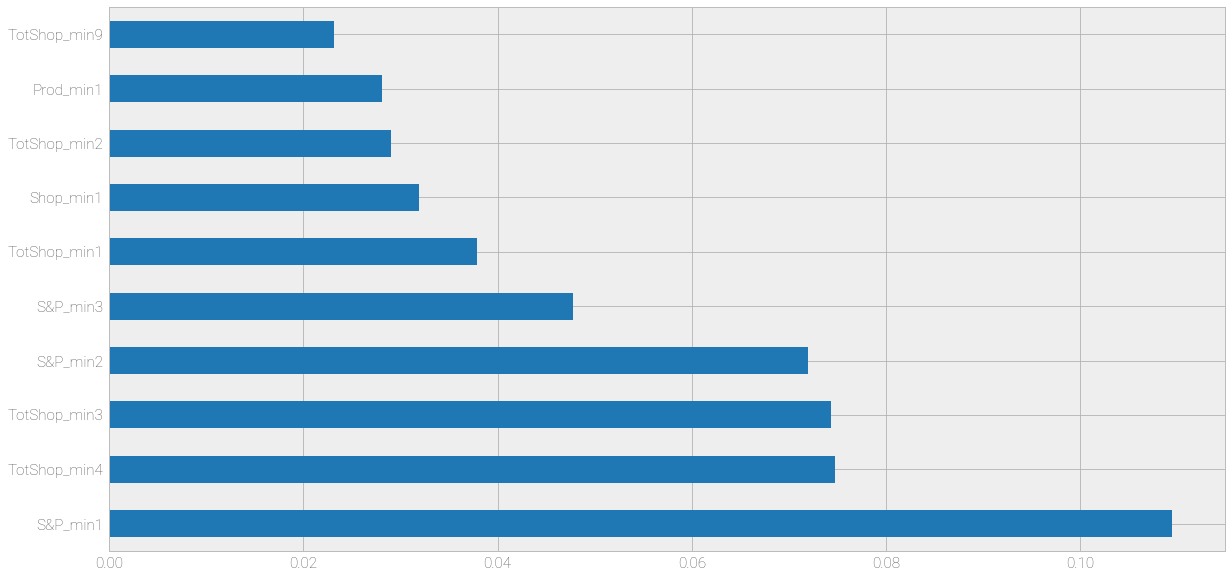

In [25]:
feat_importances = pd.Series(model.feature_importances_, index=X_train1.columns)
plt.figure(figsize=(20,10)) 
plt.rcParams.update({'font.size': 22})
feat_importances.nlargest(10).plot(kind='barh')

In [29]:
print("Number times the models match:",len(compare[compare.preds2==compare.xgb_round]))
print("vs total number of predictions:", len(compare))

Number times the models match: 32051
vs total number of predictions: 33915


In [28]:
with open('/home/cdsw/Models/xgb_1000', 'wb') as f:
    pickle.dump(model, f)

In [30]:
NovData2=pd.read_csv("/home/cdsw/Novdata_for_mod2_v2.csv")
NovData2_2=NovData2.drop(["Target"],axis="columns")
NovData2_2["AV3Months"]=NovData2_2.loc[: , "Shop_min3":"Shop_min1"].mean(axis=1)
NovData2_2.drop(NovData2_2.columns.to_series().loc["Unnamed: 0":"shop_id"],axis=1,inplace=True)

#predict the results from the remaining data
preds2=pd.Series(model.predict(NovData2_2))

In [31]:
submission=pd.read_csv("/home/cdsw/01_future-sales/data/test.csv")
#Need to append to orig data sets
prep2=NovData2.loc[:,["shop_id","item_id"]]
prep2.reset_index(drop=True,inplace=True)
prep2["Sales_preds2"]=preds2

sub2=pd.merge(submission, prep2, how="left", on=["shop_id","item_id"])

In [36]:
sub3=sub2.fillna(0)
sub3.drop(["shop_id","item_id"],axis=1, inplace=True)
sub3.columns=["ID","item_cnt_month"]
sub3.to_csv("/home/cdsw/Submission_on_data2_xgb1000.csv",index=False)
sub3.head()

,ID,item_cnt_month
0,0,1.401988
1,1,0.000000
2,2,1.744297
3,3,1.101410
4,4,0.000000
